In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

1- Fonctions d'activation et utilitaires

In [ ]:
def relu(x):
    """ReLU activation: max(0, x)"""
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    """ Derivative of ReLU: 1 if x > 0, else 0 """
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = (x > 0).astype(float)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def softmax(x):
    """Softmax activation: exp(x) / sum(exp(x))"""
    assert isinstance(x, np.ndarray), "Input to softmax must be a numpy array"
    # Stabilité numérique
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    result = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    assert np.all((result >= 0) & (result <= 1)), "Softmax output must be in [0, 1]"
    assert np.allclose(np.sum(result, axis=1), 1, atol=1e-6), "Softmax output must sum to 1 per sample"
    return result

2- Classe du réseau de neurones multicouches

In [ ]:
class MultiClassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, lambda_reg=0.001, use_adam=False):
        """
        Initialise le réseau neuronal avec les paramètres donnés
        layer_sizes: Liste des tailles de couches [input, hidden1, ..., output]
        learning_rate: Taux d'apprentissage
        lambda_reg: Coefficient de régularisation L2
        use_adam: Utiliser l'optimiseur Adam
        """
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2, "layer_sizes doit être une liste d'au moins 2 éléments"
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes), "Toutes les tailles de couches doivent être des entiers positifs"
        
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.lambda_reg = lambda_reg
        self.use_adam = use_adam
        self.weights = []
        self.biases = []
        
        # Initialisation Adam
        if self.use_adam:
            self.m_w = []
            self.v_w = []
            self.m_b = []
            self.v_b = []
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.epsilon = 1e-8
            self.t = 0  # Compteur d'itérations

        # Initialisation des poids et biais
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            # He initialization pour ReLU
            std_dev = np.sqrt(2. / layer_sizes[i])
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * std_dev
            b = np.zeros((1, layer_sizes[i+1]))
            
            self.weights.append(w)
            self.biases.append(b)
            
            if self.use_adam:
                self.m_w.append(np.zeros_like(w))
                self.v_w.append(np.zeros_like(w))
                self.m_b.append(np.zeros_like(b))
                self.v_b.append(np.zeros_like(b))

    def forward(self, X):
        """Propagation avant à travers le réseau"""
        assert isinstance(X, np.ndarray), "L'entrée X doit être un tableau numpy"
        assert X.shape[1] == self.layer_sizes[0], f"Dimension d'entrée ({X.shape[1]}) doit correspondre à la couche d'entrée ({self.layer_sizes[0]})"
        
        self.activations = [X]
        self.z_values = []
        
        # Propagation à travers les couches cachées (ReLU)
        for i in range(len(self.weights) - 1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]
            a = relu(z)
            self.z_values.append(z)
            self.activations.append(a)
        
        # Couche de sortie (Softmax)
        z_output = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        output = softmax(z_output)
        self.z_values.append(z_output)
        self.activations.append(output)
        
        return output

    def compute_loss(self, y_true, y_pred):
        """Calcule la perte d'entropie croisée avec régularisation L2"""
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Les entrées doivent être des tableaux numpy"
        assert y_true.shape == y_pred.shape, "y_true et y_pred doivent avoir la même forme"
        
        # Éviter log(0)
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        
        # Perte d'entropie croisée
        cross_entropy = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
        
        # Régularisation L2
        l2_reg = 0
        for w in self.weights:
            l2_reg += np.sum(np.square(w))
        l2_reg = (self.lambda_reg / (2 * y_true.shape[0])) * l2_reg
        
        total_loss = cross_entropy + l2_reg
        assert not np.isnan(total_loss), "Le calcul de la perte a produit NaN"
        return total_loss

    def compute_accuracy(self, y_true, y_pred):
        """Calcule la précision de classification"""
        assert isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray), "Les entrées doivent être des tableaux numpy"
        assert y_true.shape == y_pred.shape, "y_true et y_pred doivent avoir la même forme"
        
        predictions = np.argmax(y_pred, axis=1)
        if y_true.ndim > 1:  # Si one-hot encoded
            true_labels = np.argmax(y_true, axis=1)
        else:
            true_labels = y_true
            
        accuracy = np.mean(predictions == true_labels)
        assert 0 <= accuracy <= 1, "La précision doit être entre 0 et 1"
        return accuracy

    def backward(self, X, y, outputs):
        """Rétropropagation avec régularisation L2"""
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs, np.ndarray), "Les entrées doivent être des tableaux numpy"
        m = X.shape[0]
        
        # Initialisation des gradients
        d_weights = [np.zeros_like(w) for w in self.weights]
        d_biases = [np.zeros_like(b) for b in self.biases]
        
        # Gradient pour la couche de sortie (softmax + entropie croisée)
        dZ = (outputs - y) / m
        
        # Calcul des gradients pour la dernière couche
        d_weights[-1] = self.activations[-2].T @ dZ
        d_biases[-1] = np.sum(dZ, axis=0, keepdims=True)
        
        # Ajout de la régularisation L2
        d_weights[-1] += (self.lambda_reg / m) * self.weights[-1]
        
        # Rétropropagation à travers les couches cachées
        for l in range(len(self.weights)-2, -1, -1):
            dA = dZ @ self.weights[l+1].T
            dZ = dA * relu_derivative(self.z_values[l])
            
            d_weights[l] = self.activations[l].T @ dZ
            d_biases[l] = np.sum(dZ, axis=0, keepdims=True)
            
            # Ajout de la régularisation L2
            d_weights[l] += (self.lambda_reg / m) * self.weights[l]
        
        # Mise à jour des paramètres
        self.t += 1
        for i in range(len(self.weights)):
            if self.use_adam:
                # Mise à jour des moments pour Adam
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * d_weights[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (d_weights[i] ** 2)
                
                # Correction de biais
                m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
                
                # Mise à jour des poids
                self.weights[i] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                
                # Même processus pour les biais
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * d_biases[i]
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (d_biases[i] ** 2)
                
                m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)
                
                self.biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
            else:
                # Mise à jour SGD standard
                self.weights[i] -= self.learning_rate * d_weights[i]
                self.biases[i] -= self.learning_rate * d_biases[i]

    def train(self, X, y, X_val, y_val, epochs, batch_size, use_augmentation=False):
        """Entraîne le réseau avec mini-batch SGD et validation"""
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X et y doivent être des tableaux numpy"
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        
        for epoch in range(epochs):
            # Mélange des données
            indices = np.random.permutation(X.shape[0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                # Création du batch
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # Augmentation de données
                if use_augmentation:
                    X_batch = self.augment_batch(X_batch)
                
                # Propagation avant
                outputs = self.forward(X_batch)
                batch_loss = self.compute_loss(y_batch, outputs)
                epoch_loss += batch_loss
                
                # Rétropropagation
                self.backward(X_batch, y_batch, outputs)
            
            # Calcul des métriques après chaque epoch
            train_outputs = self.forward(X)
            train_loss = self.compute_loss(y, train_outputs)
            train_acc = self.compute_accuracy(y, train_outputs)
            
            val_outputs = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_outputs)
            val_acc = self.compute_accuracy(y_val, val_outputs)
            
            # Enregistrement des résultats
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            
            # Affichage des progrès
            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
        
        return train_losses, val_losses, train_accuracies, val_accuracies

    def augment_batch(self, X_batch):
        """Applique une augmentation de données à un batch d'images"""
        augmented = []
        for img_flat in X_batch:
            # Reconstruction de l'image 32x32
            img = img_flat.reshape(32, 32)
            
            # Rotation aléatoire (±15°)
            angle = np.random.uniform(-15, 15)
            M_rot = cv2.getRotationMatrix2D((16, 16), angle, 1.0)
            img = cv2.warpAffine(img, M_rot, (32, 32))
            
            # Translation aléatoire (±2 pixels)
            tx, ty = np.random.randint(-2, 3, size=2)
            M_trans = np.float32([[1, 0, tx], [0, 1, ty]])
            img = cv2.warpAffine(img, M_trans, (32, 32))
            
            # Remise à plat
            augmented.append(img.flatten())
        
        return np.array(augmented)

    def predict(self, X):
        """Prédit les classes pour les données d'entrée"""
        outputs = self.forward(X)
        predictions = np.argmax(outputs, axis=1)
        return predictions

    def cross_validate(self, X, y, k=5, epochs=50, batch_size=32):
        """Validation croisée k-fold"""
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        fold_accuracies = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            print(f"\n=== Fold {fold+1}/{k} ===")
            
            # Division des données
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Réinitialisation des poids
            self.__init__(self.layer_sizes, self.learning_rate, self.lambda_reg, self.use_adam)
            
            # Entraînement
            self.train(X_train, y_train, X_val, y_val, epochs, batch_size)
            
            # Évaluation
            y_pred = self.predict(X_val)
            accuracy = np.mean(y_pred == np.argmax(y_val, axis=1))
            fold_accuracies.append(accuracy)
            print(f"Fold {fold+1} Accuracy: {accuracy:.4f}")
        
        print(f"\n=== {k}-Fold CV Results ===")
        print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
        return fold_accuracies

3- Chargement et prétraitement des données

In [4]:
def load_and_preprocess_image(image_path, target_size=(32, 32)):
    """Charge et prétraite une image"""
    assert os.path.exists(image_path), f"Image non trouvée: {image_path}"
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    assert img is not None, f"Échec du chargement: {image_path}"
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0  # Normalisation
    return img.flatten()  # Aplatir pour le réseau


- Chemin vers les données (à adapter selon votre configuration)

In [5]:
data_dir = os.path.join(os.getcwd(), 'amhcd-data-64/tifinagh-images/')

- Chargement des étiquettes

In [6]:
try:
    labels_df = pd.read_csv(os.path.join(data_dir, 'amhcd-data-64/labels-map.csv'))
    assert 'image_path' in labels_df.columns and 'label' in labels_df.columns, "CSV must contain 'image_path' and 'label' columns"
except FileNotFoundError:
    print("labels-map.csv not found. Building DataFrame from directory structure...")
    # Alternative : construire un DataFrame à partir des dossiers
    image_paths = []
    labels = []
    
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                # Ajouter uniquement les fichiers (pas les dossiers)
                img_path = os.path.join(label_path, img_name)
                if os.path.isfile(img_path):
                    image_paths.append(img_path)
                    labels.append(label_dir)
    
    # Créer le DataFrame après la collecte
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})


labels-map.csv not found. Building DataFrame from directory structure...


- Encodage des étiquettes

In [7]:
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

- Chargement des images

In [8]:
X = np.array([load_and_preprocess_image(os.path.join(data_dir, path)) for path in labels_df['image_path']])
y = labels_df['label_encoded'].values

- Division des données

In [9]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

- Encodage one-hot

In [10]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_val_one_hot = one_hot_encoder.transform(y_val.reshape(-1, 1))
y_test_one_hot = one_hot_encoder.transform(y_test.reshape(-1, 1))

- Entraînement et évaluation

In [11]:
# Configuration du réseau
layer_sizes = [X_train.shape[1], 64, 32, num_classes]

In [12]:
# Création du modèle avec Adam et régularisation
nn = MultiClassNeuralNetwork(
    layer_sizes, 
    learning_rate=0.001, 
    lambda_reg=0.0001, 
    use_adam=True
)

In [13]:
# Validation croisée (optionnelle)
# fold_accuracies = nn.cross_validate(X_temp, y_temp_one_hot, k=5, epochs=50)

# Entraînement avec augmentation de données
train_losses, val_losses, train_accs, val_accs = nn.train(
    X_train, y_train_one_hot, 
    X_val, y_val_one_hot,
    epochs=100, 
    batch_size=64,
    use_augmentation=True
)

Epoch 0/100 - Train Loss: 2.0546, Val Loss: 2.0670, Train Acc: 0.4167, Val Acc: 0.4116
Epoch 10/100 - Train Loss: 0.8742, Val Loss: 0.9124, Train Acc: 0.7285, Val Acc: 0.7190
Epoch 20/100 - Train Loss: 0.6672, Val Loss: 0.7051, Train Acc: 0.7897, Val Acc: 0.7754
Epoch 30/100 - Train Loss: 0.5953, Val Loss: 0.6297, Train Acc: 0.8130, Val Acc: 0.7988
Epoch 40/100 - Train Loss: 0.5294, Val Loss: 0.5850, Train Acc: 0.8307, Val Acc: 0.8066
Epoch 50/100 - Train Loss: 0.4719, Val Loss: 0.5152, Train Acc: 0.8479, Val Acc: 0.8343
Epoch 60/100 - Train Loss: 0.4529, Val Loss: 0.5021, Train Acc: 0.8518, Val Acc: 0.8418
Epoch 70/100 - Train Loss: 0.4140, Val Loss: 0.4695, Train Acc: 0.8638, Val Acc: 0.8465
Epoch 80/100 - Train Loss: 0.3923, Val Loss: 0.4331, Train Acc: 0.8684, Val Acc: 0.8579
Epoch 90/100 - Train Loss: 0.3766, Val Loss: 0.4077, Train Acc: 0.8728, Val Acc: 0.8671


- Évaluation finale sur le test set

In [14]:
y_pred = nn.predict(X_test)
test_accuracy = nn.compute_accuracy(y_test_one_hot, nn.forward(X_test))
print("\n=== Rapport de classification ===")
print(classification_report(
    y_test, 
    y_pred, 
    target_names=label_encoder.classes_
))
print(f"Test Accuracy: {test_accuracy:.4f}")



=== Rapport de classification ===
              precision    recall  f1-score   support

          ya       0.75      0.98      0.85       171
         yab       0.77      0.77      0.77       171
        yach       0.89      0.80      0.84       171
         yad       0.85      0.92      0.88       171
        yadd       0.73      0.87      0.79       171
         yae       0.92      0.91      0.91       171
         yaf       0.87      0.89      0.88       171
         yag       0.89      0.90      0.89       171
        yagg       0.95      0.91      0.93       170
        yagh       0.96      0.90      0.93       170
         yah       0.89      0.85      0.87       171
        yahh       0.85      0.99      0.92       171
         yaj       0.90      0.78      0.84       171
         yak       0.91      0.81      0.86       171
        yakk       0.94      0.93      0.93       171
         yal       0.94      0.89      0.92       170
         yam       0.91      0.97      0.94   

- Visualisations

In [15]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Matrice de confusion')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.close()

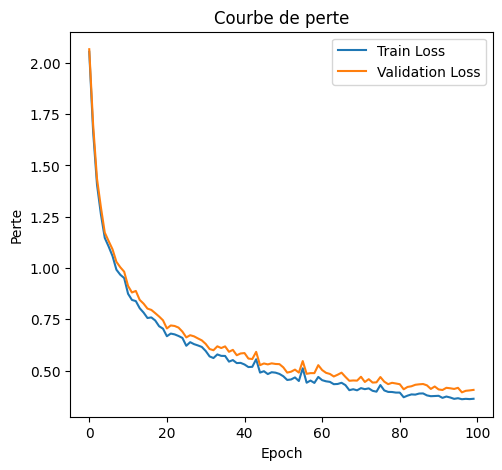

In [16]:
# Courbes d'apprentissage
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Courbe de perte')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.legend()


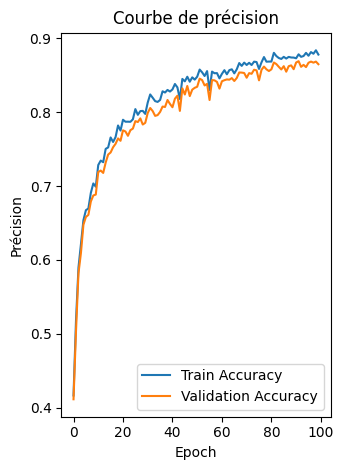

In [17]:
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Courbe de précision')
plt.xlabel('Epoch')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves.png')
plt.show()

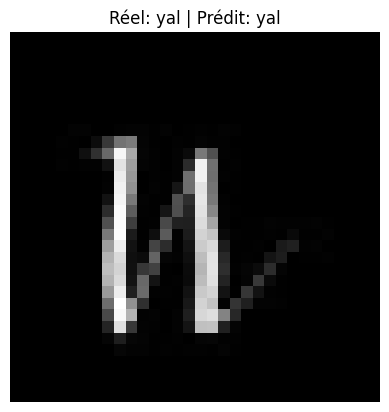

In [18]:
# Exemple de prédiction
sample_idx = np.random.randint(0, len(X_test))
sample_img = X_test[sample_idx].reshape(32, 32)
true_label = label_encoder.classes_[y_test[sample_idx]]
pred_label = label_encoder.classes_[y_pred[sample_idx]]

plt.imshow(sample_img, cmap='gray')
plt.title(f"Réel: {true_label} | Prédit: {pred_label}")
plt.axis('off')
plt.savefig('sample_prediction.png')
plt.show()